<a href="https://colab.research.google.com/github/FokrulBhuiyan/Machine-Learning/blob/master/Copy_of_SANDP500_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking
import matplotlib.pyplot as plt

# Load and preprocess the dataset

In [ ]:
# Load the CSV data into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Dataset/SANDP500.csv', parse_dates=['Date'])

# Sort the DataFrame by the "Date" column in ascending order
df.sort_values(by='Date', inplace=True)

# Display the first few rows of the data to get an initial view
print(df.head())

           Date      Open      High       Low     Close Adj_Close  \
5722 2001-01-31  1,373.73  1,383.37  1,364.66  1,366.01  1,366.01   
5721 2001-02-01  1,366.01  1,373.50  1,359.34  1,373.47  1,373.47   
5720 2001-02-02  1,373.47  1,376.38  1,348.72  1,349.47  1,349.47   
5719 2001-02-05  1,349.47  1,354.56  1,344.48  1,354.31  1,354.31   
5718 2001-02-06  1,354.31  1,363.55  1,350.04  1,352.26  1,352.26   

             Volume  
5722  1,295,300,000  
5721  1,118,800,000  
5720  1,048,400,000  
5719  1,013,000,000  
5718  1,059,600,000  


In [ ]:
first_close_value_str = str(df['Close'].iloc[0])
# Remove commas from both 'Close' and 'Volume' columns and convert them to numeric
if ',' in first_close_value_str:
  # Filter out rows with missing values in the "Volume" column
  df = df.dropna(subset=['Volume'])

  columns_to_convert = ['Close', 'Open', 'High', 'Low', 'Adj_Close']

  for column in columns_to_convert:
      df[column] = df[column].str.replace(',', '').astype(float)

  # Convert the "Date" column to a datetime column
  df['Date'] = pd.to_datetime(df['Date'])

  # Set "Date" as the index
  df.set_index('Date', inplace=True)
  print(df.sample(5))

else:
  print(df.head(5))

               Open     High      Low    Close  Adj_Close         Volume
Date                                                                    
2011-08-11  1121.30  1186.29  1121.30  1172.64    1172.64  3,685,050,000
2017-12-28  2686.10  2687.66  2682.69  2687.54    2687.54  2,174,890,000
2018-03-16  2750.57  2761.85  2749.97  2752.01    2752.01  5,429,140,000
2023-03-16  3878.93  3964.46  3864.11  3960.28    3960.28  5,695,790,000
2012-12-27  1419.83  1422.80  1401.80  1418.10    1418.10  2,830,180,000


# Data normalization

In [ ]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1, 1))


# Create sequences for LSTM

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Set sequence length
seq_length = 10

# Create sequences
sequences = create_sequences(df['Close'].values, seq_length)

# Split the data into input (X) and output (y)
X = np.array([seq[:-1] for seq in sequences])  # Exclude the last element from each sequence
y = np.array([seq[-1] for seq in sequences])   # Take the last element from each sequence

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print("Shape of X_train:", X_train.shape)


Shape of X_train: (4571, 9)


In [ ]:
print("Shape of X_train:", X_test.shape)

Shape of X_train: (1143, 9)


# Build and train the LSTM model 0

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(40, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Masking(mask_value=0.2))  # Assuming input data has 3 features
model.add(LSTM(units=10, return_sequences = False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
143/143 [==============================] - 5s 13ms/step - loss: 0.0137
Epoch 2/10
143/143 [==============================] - 1s 6ms/step - loss: 1.3672e-04
Epoch 3/10
143/143 [==============================] - 1s 6ms/step - loss: 1.2706e-04
Epoch 4/10
143/143 [==============================] - 1s 7ms/step - loss: 1.2934e-04
Epoch 5/10
143/143 [==============================] - 1s 7ms/step - loss: 1.2516e-04
Epoch 6/10
143/143 [==============================] - 1s 7ms/step - loss: 1.2647e-04
Epoch 7/10
143/143 [==============================] - 1s 7ms/step - loss: 1.2446e-04
Epoch 8/10
143/143 [==============================] - 1s 7ms/step - loss: 1.2534e-04
Epoch 9/10
143/143 [==============================] - 1s 7ms/step - loss: 1.1825e-04
Epoch 10/10
143/143 [==============================] - 1s 7ms/step - loss: 1.1557e-04


In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 2ms/step - loss: 1.3035e-04
Mean Squared Error on Test Set: 0.0001303526369156316
36/36 [==============================] - 1s 2ms/step
       Actual    Predicted
0     1433.27  1454.913452
1     1829.83  1773.059692
2      942.30   913.589233
3     3770.55  3825.747559
4     4587.18  4493.331055
...       ...          ...
1138  1122.41  1118.158325
1139  1101.39  1099.273682
1140  1413.58  1403.611694
1141  1165.81  1140.565430
1142  2790.37  2689.643799

[1143 rows x 2 columns]


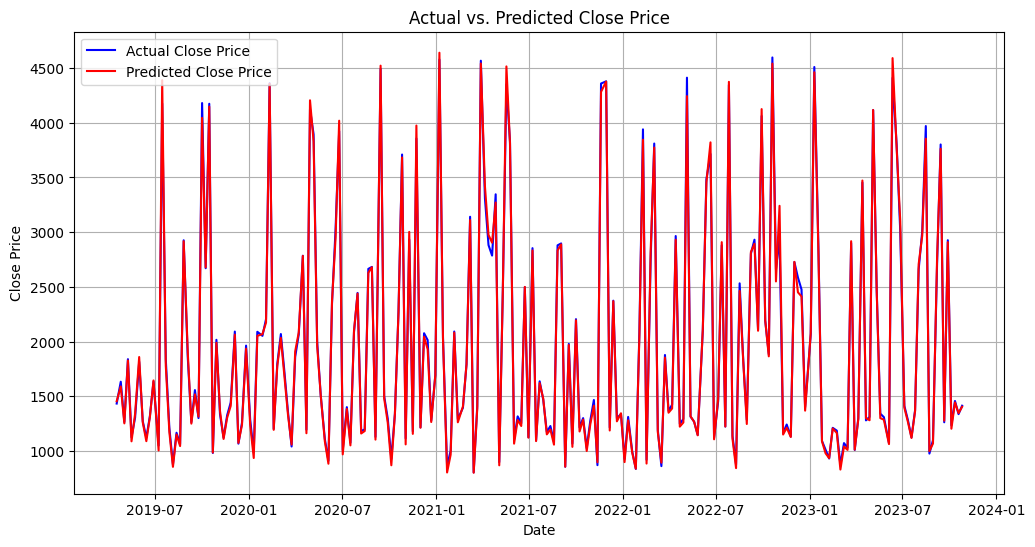

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


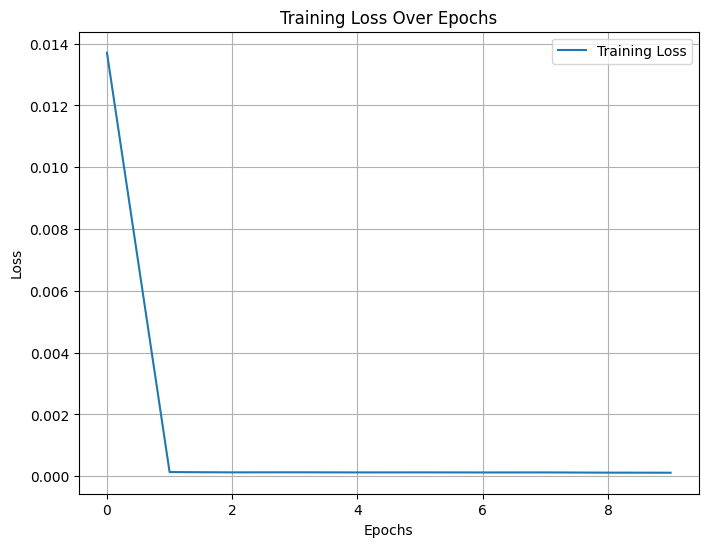

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 9, 40)             6720      
                                                                 
 lstm_13 (LSTM)              (None, 10)                2040      
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 8771 (34.26 KB)
Trainable params: 8771 (34.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Build and train the LSTM model 1

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(40, activation="relu", return_sequences=True, dropout=0.2, input_shape=(X_train.shape[1], 1)))
# model.add(Masking(mask_value=0.2))  # Assuming input data has 3 features
model.add(LSTM(units=10, return_sequences = False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
143/143 [==============================] - 4s 6ms/step - loss: 0.0297
Epoch 2/10
143/143 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 3/10
143/143 [==============================] - 1s 7ms/step - loss: 3.6881e-04
Epoch 4/10
143/143 [==============================] - 1s 6ms/step - loss: 3.1153e-04
Epoch 5/10
143/143 [==============================] - 1s 7ms/step - loss: 3.2568e-04
Epoch 6/10
143/143 [==============================] - 1s 7ms/step - loss: 2.3727e-04
Epoch 7/10
143/143 [==============================] - 1s 7ms/step - loss: 2.3315e-04
Epoch 8/10
143/143 [==============================] - 1s 7ms/step - loss: 1.7507e-04
Epoch 9/10
143/143 [==============================] - 1s 7ms/step - loss: 2.0913e-04
Epoch 10/10
143/143 [==============================] - 1s 7ms/step - loss: 2.7831e-04


# Evaluate the model 1

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 2ms/step - loss: 0.0062
Mean Squared Error on Test Set: 0.006247259210795164
36/36 [==============================] - 1s 3ms/step
       Actual    Predicted
0     1433.27  1300.097168
1     1829.83  1542.779175
2      942.30   852.531799
3     3770.55  3238.083252
4     4587.18  3766.591797
...       ...          ...
1138  1122.41  1025.194458
1139  1101.39  1010.005798
1140  1413.58  1261.369629
1141  1165.81  1043.984985
1142  2790.37  2289.647949

[1143 rows x 2 columns]


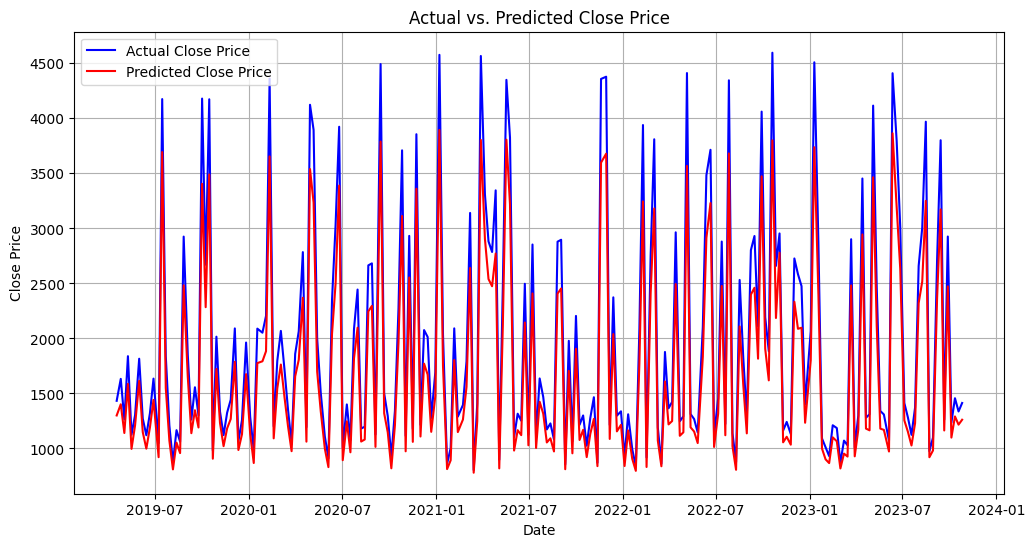

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.index[-len(y_test):][::subset_interval]

DatetimeIndex(['2019-04-17', '2019-04-25', '2019-05-02', '2019-05-09',
               '2019-05-16', '2019-05-23', '2019-05-31', '2019-06-07',
               '2019-06-14', '2019-06-21',
               ...
               '2023-08-23', '2023-08-30', '2023-09-07', '2023-09-14',
               '2023-09-21', '2023-09-28', '2023-10-05', '2023-10-12',
               '2023-10-19', '2023-10-26'],
              dtype='datetime64[ns]', name='Date', length=229, freq=None)

# Loss plot for model 1

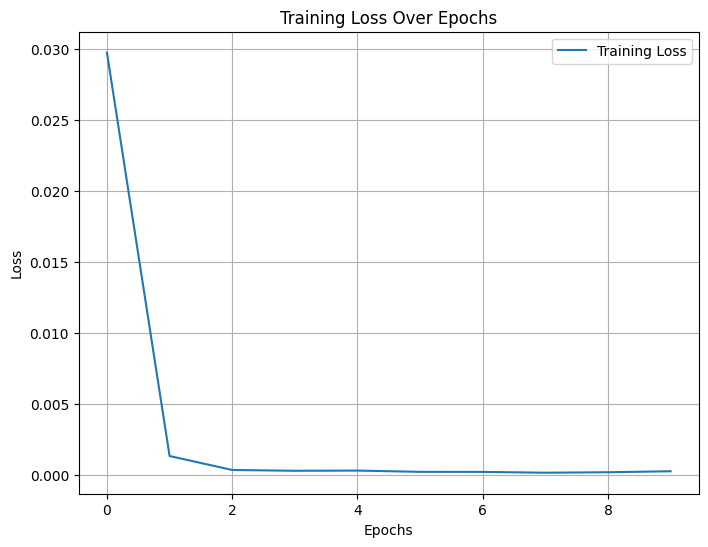

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Build and train the LSTM model 2

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=40, activation="relu",return_sequences=True, dropout=0.2, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', )

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32)


Epoch 1/30
143/143 [==============================] - 5s 10ms/step - loss: 0.0269
Epoch 2/30
143/143 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 3/30
143/143 [==============================] - 1s 7ms/step - loss: 8.6707e-04
Epoch 4/30
143/143 [==============================] - 1s 6ms/step - loss: 4.5171e-04
Epoch 5/30
143/143 [==============================] - 1s 7ms/step - loss: 2.9175e-04
Epoch 6/30
143/143 [==============================] - 1s 7ms/step - loss: 2.4516e-04
Epoch 7/30
143/143 [==============================] - 1s 7ms/step - loss: 2.1822e-04
Epoch 8/30
143/143 [==============================] - 1s 7ms/step - loss: 2.0349e-04
Epoch 9/30
143/143 [==============================] - 1s 7ms/step - loss: 1.7919e-04
Epoch 10/30
143/143 [==============================] - 1s 7ms/step - loss: 1.7711e-04
Epoch 11/30
143/143 [==============================] - 1s 8ms/step - loss: 1.8379e-04
Epoch 12/30
143/143 [==============================] - 1s 8ms/step - l

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 0s 2ms/step - loss: 0.0067
Mean Squared Error on Test Set: 0.006656093057245016
36/36 [==============================] - 0s 2ms/step
       Actual    Predicted
0     1433.27  1293.997925
1     1829.83  1556.591309
2      942.30   877.624329
3     3770.55  3209.648926
4     4587.18  3754.054199
...       ...          ...
1138  1122.41  1039.904541
1139  1101.39  1024.453247
1140  1413.58  1261.983276
1141  1165.81  1058.365967
1142  2790.37  2286.774170

[1143 rows x 2 columns]


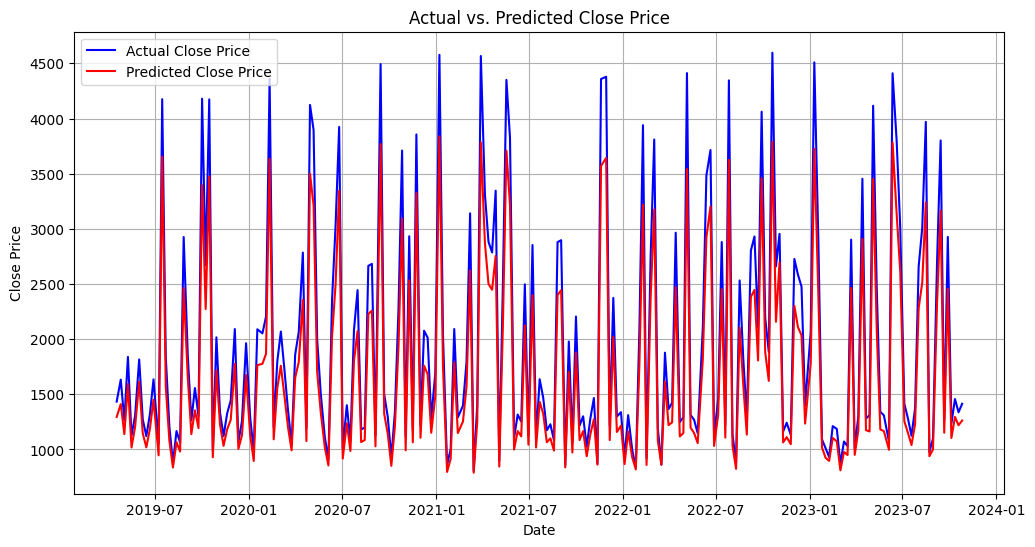

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


# Loss plot for model 2

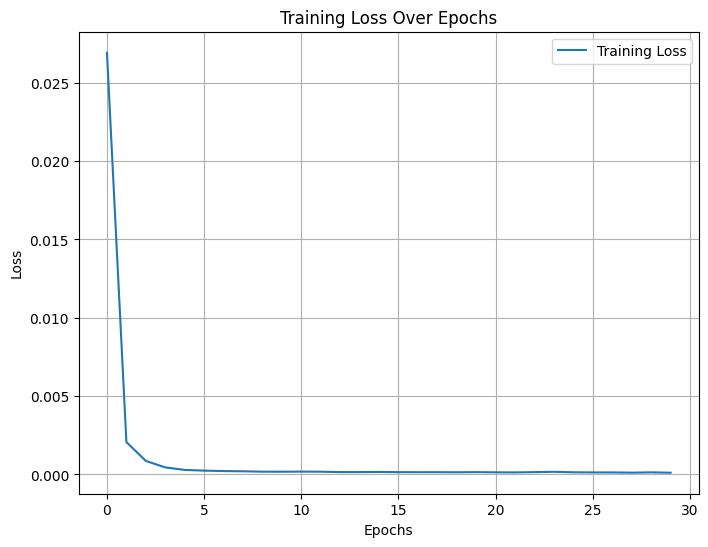

In [ ]:
# tr_loss = history.history['loss']
# index_loss = np.argmin(tr_loss)
# val_lowest = tr_loss[index_loss]
# loss_label = f'best epoch= {str(index_loss + 1)}'

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Build and train the LSTM model 3: 30 epoch without dropout

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=40, activation="relu",return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', )

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32)


Epoch 1/30
143/143 [==============================] - 4s 8ms/step - loss: 0.0196
Epoch 2/30
143/143 [==============================] - 1s 8ms/step - loss: 1.2765e-04
Epoch 3/30
143/143 [==============================] - 1s 8ms/step - loss: 1.2011e-04
Epoch 4/30
143/143 [==============================] - 1s 6ms/step - loss: 1.1620e-04
Epoch 5/30
143/143 [==============================] - 1s 6ms/step - loss: 1.1685e-04
Epoch 6/30
143/143 [==============================] - 1s 6ms/step - loss: 1.2812e-04
Epoch 7/30
143/143 [==============================] - 1s 7ms/step - loss: 1.2071e-04
Epoch 8/30
143/143 [==============================] - 1s 10ms/step - loss: 1.1491e-04
Epoch 9/30
143/143 [==============================] - 1s 6ms/step - loss: 1.1083e-04
Epoch 10/30
143/143 [==============================] - 1s 6ms/step - loss: 1.1107e-04
Epoch 11/30
143/143 [==============================] - 1s 6ms/step - loss: 1.0475e-04
Epoch 12/30
143/143 [==============================] - 1s 6ms/step

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 3ms/step - loss: 9.8527e-05
Mean Squared Error on Test Set: 9.852725634118542e-05
36/36 [==============================] - 1s 5ms/step
       Actual    Predicted
0     1433.27  1470.903198
1     1829.83  1814.076904
2      942.30   935.496704
3     3770.55  3826.091064
4     4587.18  4526.936523
...       ...          ...
1138  1122.41  1139.840820
1139  1101.39  1118.213257
1140  1413.58  1430.020996
1141  1165.81  1164.257324
1142  2790.37  2747.385010

[1143 rows x 2 columns]


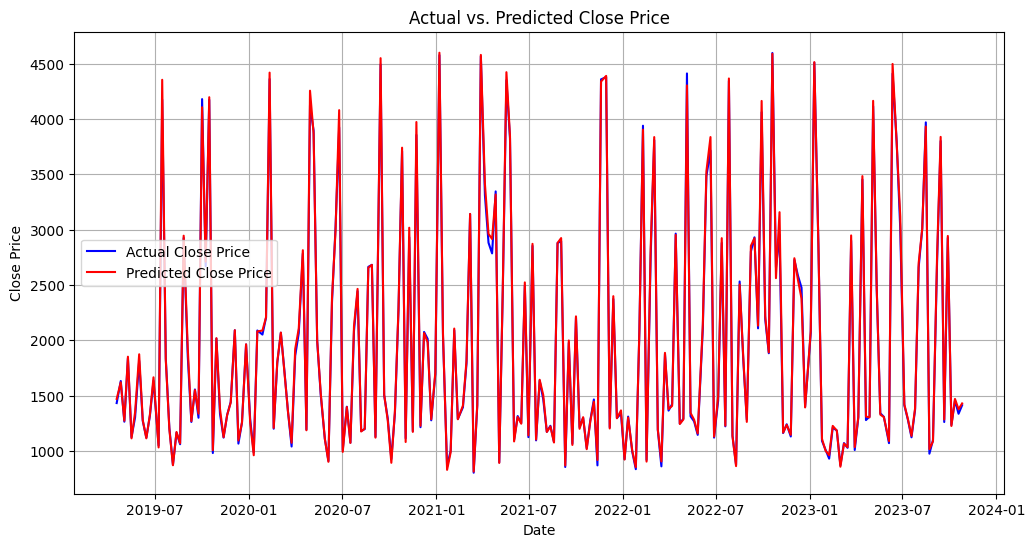

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


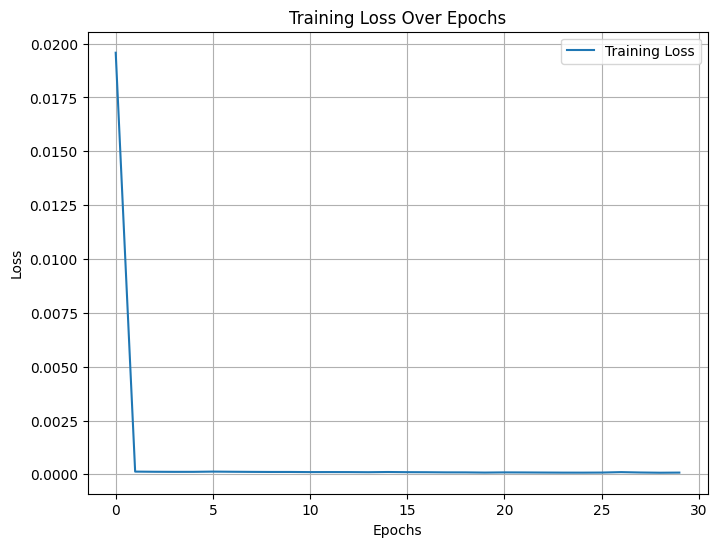

In [ ]:
# tr_loss = history.history['loss']
# index_loss = np.argmin(tr_loss)
# val_lowest = tr_loss[index_loss]
# loss_label = f'best epoch= {str(index_loss + 1)}'

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()